In [1]:
from commitfinder import UpstreamRepo
from pygit2 import Commit, Repository, Tree, Diff
import pygit2

In [2]:
# test creating an upstream repo 
origin = UpstreamRepo("https://github.com/kubernetes/kubernetes", "github")

In [3]:
# get all of the commits
commits = origin.all_commits('master')
if not commits:
    print('No commits found')
else:
    print(f'Found {len(list(commits))} commits')

Found 121239 commits


In [4]:
# let's try to understand the format of a git tree
commit = None
evaluated = 0
for c in origin.all_commits('master'):
    if c is not None:
        print(f'found a commit which we can use: {c.hex} after looking at {evaluated} commits')
        commit = c
        break
    evaluated += 1

if not commit:
    print(f'looked at {evaluated} commits but could not find one that wasnt null')

found a commit which we can use: 20a57641f83e54f94737cfc9830de5e270b0fa9e after looking at 0 commits


In [5]:
def print_commit_info(c: Commit):
    print(f'commit: {c.hex}')
    print(f'author(s): {c.author}')
    print(f'message: {c.message}')
    print(f'tree id: {c.tree_id}')
    print(f'commiter: {c.committer}')
    print(f'filemode: {c.filemode}')
    print(f'parent_ids: {c.parent_ids}')

print_commit_info(commit)

commit: 20a57641f83e54f94737cfc9830de5e270b0fa9e
author(s): openshift-merge-bot[bot] <148852131+openshift-merge-bot[bot]@users.noreply.github.com>
message: Merge pull request #1800 from sebsoto/cvemaster

OCPBUGS-22724: UPSTREAM: 121881: Use golang library instead of mklink
tree id: 6008a988f0833a24c98c051bb5c769367089ab0d
commiter: GitHub <noreply@github.com>
filemode: None
parent_ids: [4cbdd29250f42f7294c94d5ba60f4b168f6d58a2, f59457bea4cdc250aa16862669908b0184919205]


### Find a commit with renamed files

Let's look at a commit for which the operation was simply renaming files

In [6]:
renamed = []
for c in origin.all_commits('master'):
    if not c:
        continue
    if 'renamed' in c.message.lower():
        renamed.append(c)

print(f'found {len(renamed)} commits with the word "renamed" in the message')

found 131 commits with the word "renamed" in the message


### Investigate a Commit With Renamed Files

We know that the commit `8d92cfb13163f596feddfe1b5e734fd1ba4f6323` in the
[kubernetes repository](https://github.com/kubernetes/kubernetes/commit/8d92cfb13163f596feddfe1b5e734fd1ba4f6323) which contains a file rename operation.

We want to investigate and understand how this looks within the PyGit2 API.

In [7]:
commit: Commit = None
for c in renamed:
    if c.hex == '8d92cfb13163f596feddfe1b5e734fd1ba4f6323':
        commit = c
        break

print(f'found commit: {commit.hex}')

found commit: 8d92cfb13163f596feddfe1b5e734fd1ba4f6323


In [8]:
commit: Commit = commit

In [9]:
print_commit_info(commit)

commit: 8d92cfb13163f596feddfe1b5e734fd1ba4f6323
author(s): Mike Spreitzer <mspreitz@us.ibm.com>
message: Added conversions to/from NamespacedName

Also renamed file to something more on-point.

tree id: 40680b2726e60580e6c288b56e143994b0ebaa52
commiter: Mike Spreitzer <mspreitz@us.ibm.com>
filemode: None
parent_ids: [ec9515a828ec3907ffc66913947adf4e8ee7b9d6]


In [10]:
def print_tree(t: Tree):
    print(f'name: {t.name}')
    print(f'id: {t.id}')
    print(f'type: {t.type}')
    print(f'type_str: {t.type_str}')
    print(f'filemode: {t.filemode}')
    print(f'oid: {t.oid}')

print_tree(commit.tree)

name: None
id: 40680b2726e60580e6c288b56e143994b0ebaa52
type: 2
type_str: tree
filemode: None
oid: 40680b2726e60580e6c288b56e143994b0ebaa52


### View Diff Information

In [11]:
# function from commitfinder.py
def files_touched(commit: Commit) -> list:
    return [
        line.split()[-1]
        for line in origin.pyrepo.diff(commit.parents[0], commit)
        .stats.format(pygit2.GIT_DIFF_STATS_NUMBER, 10)
        .splitlines()
    ]
files_touched(commit)

['staging/src/k8s.io/client-go/tools/cache/keyfunc.go',
 'staging/src/k8s.io/client-go/tools/cache/object-names.go',
 'staging/src/k8s.io/client-go/tools/cache/object-names_test.go']

In [12]:
# lets look at the above function more closely
diff_obj = origin.pyrepo.diff(commit.parents[0], commit)
print(diff_obj.stats.format(pygit2.GIT_DIFF_STATS_NUMBER, 10))

0       50      staging/src/k8s.io/client-go/tools/cache/keyfunc.go
65      0       staging/src/k8s.io/client-go/tools/cache/object-names.go
59      0       staging/src/k8s.io/client-go/tools/cache/object-names_test.go



### What are the parents?

In [13]:
print(commit.parents)

[<pygit2.Object{commit:ec9515a828ec3907ffc66913947adf4e8ee7b9d6}>]


### Let's investigate the diff object a bit more

In [14]:
# look at the deltas
for i, d in enumerate(diff_obj.deltas):
    print(f'=== processing delta {i} ===')
    print(f'flags: {d.flags}')
    print(f'is_binary: {d.is_binary}')
    print(f'new_file: {d.new_file.path}')
    print(f'old_file: {d.old_file.path}')
    print(f'similarity: {d.similarity}')
    print(f'status: {d.status}')
    print(f'status_char: {d.status_char()}')
    if d.status == pygit2.GIT_DELTA_RENAMED:
        print(f'renamed: {d.renamed}')

=== processing delta 0 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/keyfunc.go
old_file: staging/src/k8s.io/client-go/tools/cache/keyfunc.go
similarity: 0
status: 2
status_char: D
=== processing delta 1 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/object-names.go
old_file: staging/src/k8s.io/client-go/tools/cache/object-names.go
similarity: 0
status: 1
status_char: A
=== processing delta 2 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/object-names_test.go
old_file: staging/src/k8s.io/client-go/tools/cache/object-names_test.go
similarity: 0
status: 1
status_char: A


### Detecting File Renames

According to several sources listed below, git does not actually track file renames but instead performs detection of renames.
This is done by comparing the similarity of files in the commit and the parent commit. If the similarity is above a certain threshold, then git will consider the file to be renamed.

Sources:
- [stackoverflow](https://stackoverflow.com/a/7941544)
- [blog: how does git detect file renames?](https://chelseatroy.com/2020/05/09/question-how-does-git-detect-renames/)


The specific psuedocode for this is described in the above blog:

> Here’s how git detects a rename under the hood:
> 
> 1. Were any files _deleted_ in this commit? That is, are there files that were committed in the last commit, that as of this commit, are _gone_? These are candidates files that might have been renamed.
> 1. Were any files _added_ in this commit? That is, are there files that were not there in the last commit, and as of this commit, exist? These are candidates for files _to which the deleted files_ might have been renamed.
> 1. At this point, git runs a diff algorithm on the candidate files. It would be computationally expensive to run this on the whole repo all the time if we can narrow down the rename candidates to the newly deleted files and the newly added files, which is why we do that first.
> 
> You have access to the command git uses to do this: `$git diff -M`. The command `$git diff` shows you the individual changes in a file, a branch, or the whole repo if you want, depending on what you pass in. The `-M` flag stands for “detect move” or, for our purposes, detect a rename.


This means that we need to invoke the `git diff -M` command from within PyGit2 and understand the output.

In [15]:
# lets look at the above function more closely
diff_obj = origin.pyrepo.diff(commit.parents[0], commit, flags=pygit2.GIT_DIFF_FIND_RENAMES_FROM_REWRITES)
print(diff_obj.stats.format(pygit2.GIT_DIFF_STATS_NUMBER, 10))

0       50      staging/src/k8s.io/client-go/tools/cache/keyfunc.go
65      0       staging/src/k8s.io/client-go/tools/cache/object-names.go
59      0       staging/src/k8s.io/client-go/tools/cache/object-names_test.go



In [16]:
# look at the deltas
for i, d in enumerate(diff_obj.deltas):
    print(f'=== processing delta {i} ===')
    print(f'flags: {d.flags}')
    print(f'is_binary: {d.is_binary}')
    print(f'new_file: {d.new_file.path}')
    print(f'old_file: {d.old_file.path}')
    print(f'similarity: {d.similarity}')
    print(f'status: {d.status}')
    print(f'status_char: {d.status_char()}')

=== processing delta 0 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/keyfunc.go
old_file: staging/src/k8s.io/client-go/tools/cache/keyfunc.go
similarity: 0
status: 2
status_char: D
=== processing delta 1 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/object-names.go
old_file: staging/src/k8s.io/client-go/tools/cache/object-names.go
similarity: 0
status: 1
status_char: A
=== processing delta 2 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/object-names_test.go
old_file: staging/src/k8s.io/client-go/tools/cache/object-names_test.go
similarity: 0
status: 1
status_char: A


### Invoke `git diff -M`

So passing the flag to the diff function directly doesn't seem to work,
but as shown below, the `find_similar` function is capable of performing the desired operation.

In [17]:
# use the find_similar flag on the diff object
diff_obj.find_similar()
for i, d in enumerate(diff_obj.deltas):
    print(f'=== processing delta {i} ===')
    print(f'flags: {d.flags}')
    print(f'is_binary: {d.is_binary}')
    print(f'new_file: {d.new_file.path}')
    print(f'old_file: {d.old_file.path}')
    print(f'similarity: {d.similarity}')
    print(f'status: {d.status}')
    print(f'status_char: {d.status_char()}')

=== processing delta 0 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/object-names.go
old_file: staging/src/k8s.io/client-go/tools/cache/keyfunc.go
similarity: 86
status: 4
status_char: R
=== processing delta 1 ===
flags: 2
is_binary: False
new_file: staging/src/k8s.io/client-go/tools/cache/object-names_test.go
old_file: staging/src/k8s.io/client-go/tools/cache/object-names_test.go
similarity: 0
status: 1
status_char: A


### What is the distribution of commit and parent counts?

According to the [git docs](https://git-scm.com/docs/git-commit-tree#:~:text=A%20commit%20object%20may%20have,between%20several%20lines%20of%20history.), this is what the `commit.parents` object represents:

> A commit object may have any number of parents. With exactly one parent, it is an ordinary commit. Having more than one parent makes the commit a merge between several lines of history. Initial (root) commits have no parents.



In [18]:
parent_counts = {}
for c in origin.all_commits('master'):
    count = len(c.parents)
    if count not in parent_counts:
        parent_counts[count] = 0
    parent_counts[count] += 1
print(parent_counts)

{2: 50403, 1: 70835, 0: 1}


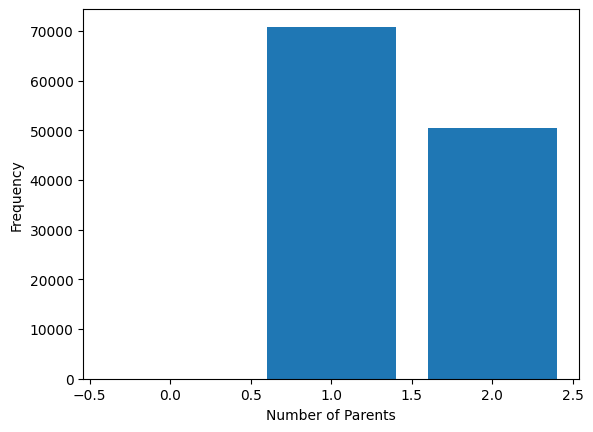

In [19]:
import matplotlib.pyplot as plt

numbers = list(parent_counts.keys())
frequencies = list(parent_counts.values())

plt.bar(numbers, frequencies)

plt.xlabel('Number of Parents')
plt.ylabel('Frequency')

plt.show()